# Stretch Processor

Set the bandwidth (Hz), the pulsewidth (s), the length of the range window (m), the target range (m) and the target radar cross section (m^2)

In [61]:
bandwidth = 1e9

pulsewidth = 10e-4

range_window_length = 50.0

target_range = [10.0, 20.0, 30.0]

target_rcs = [1.0, 10.0, 3.0]

Calculate the number of samples for stretch processing

In [62]:
from scipy import ceil

from scipy.constants import c

number_of_samples = int(ceil(4 * bandwidth * range_window_length / c))

Set the window type

In [63]:
window_type = 'Rectangular'

Get the window coefficients using `scipy.signal.windows`

In [64]:
from scipy.signal.windows import hann, hamming, blackmanharris, kaiser 

from scipy import ones


if window_type == 'Kaiser':

    coefficients = kaiser(number_of_samples, 6, True)

elif window_type == 'Blackman-Harris':

    coefficients = blackmanharris(number_of_samples, True)

elif window_type == 'Hanning':

    coefficients = hann(number_of_samples, True)

elif window_type == 'Hamming':

    coefficients = hamming(number_of_samples, True)

elif window_type == 'Rectangular':

    coefficients = ones(number_of_samples)

Get the time sampling using the `linspace` routine from `scipy`

In [65]:
from scipy import linspace

t, dt = linspace(-0.5 * pulsewidth, 0.5 * pulsewidth, number_of_samples, retstep=True)

Calculate the sampled signal after the mixing process

In [66]:
from scipy import zeros, sqrt, exp

from scipy.constants import pi


so = zeros(number_of_samples, dtype=complex)

for r, rcs in zip(target_range, target_rcs):

    so += sqrt(rcs) * exp(1j * 2.0 * pi * bandwidth / pulsewidth * (2 * r / c) * t)

Perform the FFT on the sampled signal using the routines from `fftpack`

In [67]:
from scipy.fftpack import fftfreq, fft, fftshift


# Fourier transform

so = fftshift(fft(so * coefficients, 4 * number_of_samples))



# FFT frequencies

frequencies = fftshift(fftfreq(4 * number_of_samples, dt))

Calculate the range window (m) from the frequencies (Hz)

In [68]:
# Range window

range_window = 0.5 * frequencies * c * pulsewidth / bandwidth

Display the results of stretch processing using the `matplotlib` routines

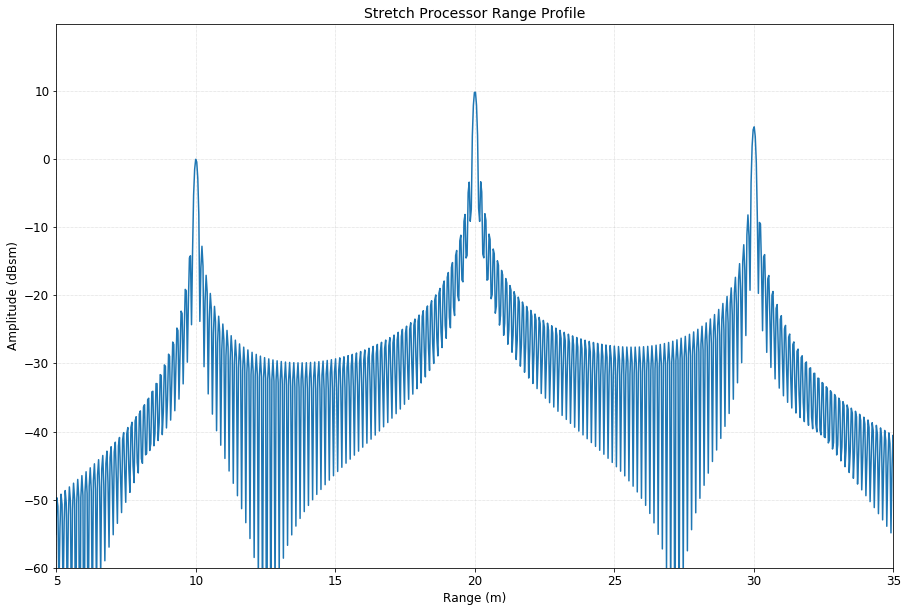

In [69]:
from matplotlib import pyplot as plt

from scipy import log10, finfo


# Set the figure size

plt.rcParams["figure.figsize"] = (15, 10)



# Create the line plot

plt.plot(range_window, 20.0 * log10(abs(so) / number_of_samples + finfo(float).eps), '')

plt.xlim(min(target_range) - 5, max(target_range) + 5)

plt.ylim(-60, max(20.0 * log10(abs(so) / number_of_samples)) + 10)



# Set the x and y axis labels

plt.xlabel("Range (m)", size=12)

plt.ylabel("Amplitude (dBsm)", size=12)



# Turn on the grid

plt.grid(linestyle=':', linewidth=0.5)



# Set the plot title and labels

plt.title('Stretch Processor Range Profile', size=14)



# Set the tick label size

plt.tick_params(labelsize=12)